# Exploratory Data Analysis: aligned_wrist_data_64Hz.csv

This notebook performs EDA on the wrist sensor dataset containing **BVP** (Blood Volume Pulse) and **EDA** (Electrodermal Activity) signals sampled at 64 Hz, with **labels** from the WESAD stress study: 0=baseline, 1=stress, 2=amusement, -1=other/transition.

In [ ]:
! pip install pandas numpy matplotlib seaborn


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
plt.style.use('ggplot')

DATA_PATH = '/Users/mostafazamaniturk/Documents/USD/AAI-530/work/edaFolder/aligned_wrist_data_64Hz.csv'

## 1. Load Data & Basic Info

In [24]:
df = pd.read_csv(DATA_PATH)
df.head(10)

,subject,time_sec,bvp,eda,label
0,S2,0.000000,-59.37,1.138257,-1
1,S2,0.015625,-53.42,1.137456,-1
2,S2,0.031250,-44.40,1.136655,-1
3,S2,0.046875,-33.17,1.135855,-1
4,S2,0.062500,-20.79,1.135054,-1
5,S2,0.078125,-8.33,1.134253,-1
6,S2,0.093750,3.40,1.133452,-1
7,S2,0.109375,13.85,1.132651,-1
8,S2,0.125000,22.76,1.131851,-1
9,S2,0.140625,30.04,1.131050,-1


In [25]:
df.tail(10)

,subject,time_sec,bvp,eda,label
545671,S17,512.453125,-173.37,0.783331,-1
545672,S17,512.468750,-168.57,0.783331,-1
545673,S17,512.484375,-163.88,0.783331,-1
545674,S17,512.500000,-157.92,0.783331,-1
545675,S17,512.515625,-155.25,0.783331,-1
545676,S17,512.531250,-151.22,0.783331,-1
545677,S17,512.546875,-145.36,0.783331,-1
545678,S17,512.562500,-138.09,0.783331,-1
545679,S17,512.578125,-123.80,0.783331,-1
545680,S17,512.593750,-112.88,0.783331,-1


In [26]:
print('Shape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nData types:')
print(df.dtypes)
print('\nMemory usage:', df.memory_usage(deep=True).sum() / 1024**2, 'MB')

Shape: (545681, 5)

Columns: ['subject', 'time_sec', 'bvp', 'eda', 'label']

Data types:
subject      object
time_sec    float64
bvp         float64
eda         float64
label         int64
dtype: object

Memory usage: 47.57805824279785 MB


## 2. Label Distribution

WESAD labels: **0**=baseline, **1**=stress, **2**=amusement, **-1**=other/transition (Medi, Read events).

Label distribution:
  other (-1): 509,467 (93.4%)
  baseline (0): 19,120 (3.5%)
  stress (1): 10,925 (2.0%)
  amusement (2): 6,169 (1.1%)

Three-class (0,1,2) samples: 36,214


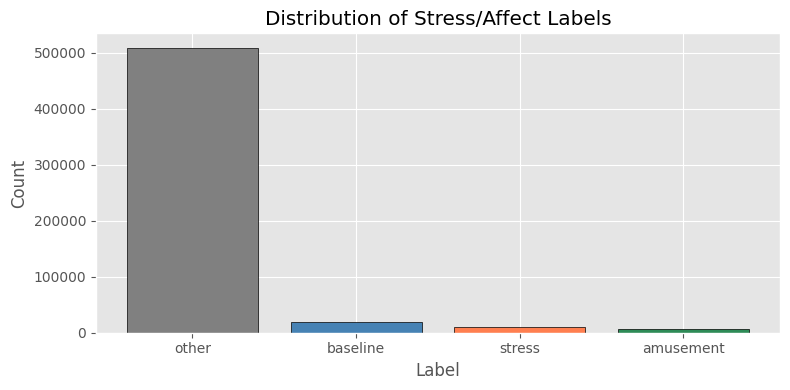

In [27]:
# Label distribution
label_counts = df['label'].value_counts().sort_index()
label_names = {-1: 'other', 0: 'baseline', 1: 'stress', 2: 'amusement'}
print('Label distribution:')
for k, v in label_counts.items():
    print(f'  {label_names.get(k, k)} ({k}): {v:,} ({100*v/len(df):.1f}%)')
print(f'\nThree-class (0,1,2) samples: {(df["label"] >= 0).sum():,}')

fig, ax = plt.subplots(figsize=(8, 4))
labels_sorted = sorted(label_counts.index)
colors = ['gray', 'steelblue', 'coral', 'seagreen']
ax.bar([label_names.get(l, str(l)) for l in labels_sorted], 
       [label_counts[l] for l in labels_sorted], 
       color=[colors[i] for i in range(len(labels_sorted))], edgecolor='black')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Distribution of Stress/Affect Labels')
plt.tight_layout()
plt.show()

### BVP and EDA by Label

Compare signal statistics across stress conditions.

BVP and EDA statistics by label:
          bvp              eda        
         mean      std    mean     std
label                                 
0     -0.2627  46.3359  2.3606  2.7163
1     -0.4517  78.6593  2.2223  2.5855
2     -1.5393  69.7963  2.5241  2.7930


/var/folders/j_/2nhf1vq11vx6vp8923wmdmx40000gn/T/ipykernel_7032/3093577006.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_label, labels=order, patch_artist=True)
/var/folders/j_/2nhf1vq11vx6vp8923wmdmx40000gn/T/ipykernel_7032/3093577006.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_label, labels=order, patch_artist=True)


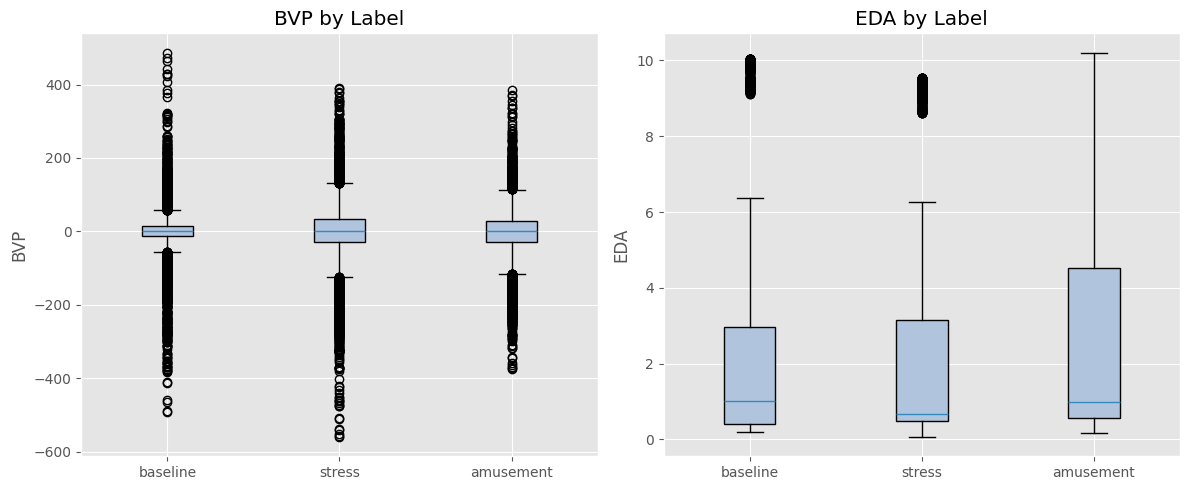

In [28]:
# Filter to three-class labels (exclude -1) for cleaner comparison
df_labels = df[df['label'] >= 0].copy()
df_labels['label_name'] = df_labels['label'].map(label_names)

# Per-label statistics
agg_label = df_labels.groupby('label').agg({'bvp': ['mean', 'std'], 'eda': ['mean', 'std']})
print('BVP and EDA statistics by label:')
print(agg_label.round(4))

# Boxplots by label (order: baseline, stress, amusement)
order = ['baseline', 'stress', 'amusement']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, col in zip(axes, ['bvp', 'eda']):
    data_by_label = [df_labels[df_labels['label'] == k][col] for k in [0, 1, 2]]
    bp = ax.boxplot(data_by_label, labels=order, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightsteelblue')
    ax.set_title(f'{col.upper()} by Label')
    ax.set_ylabel(col.upper())
plt.tight_layout()
plt.show()

## 2. Missing Values

In [29]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})

,Missing Count,Missing %
subject,0,0.0
time_sec,0,0.0
bvp,0,0.0
eda,0,0.0
label,0,0.0


## 3. Statistical Summary

In [30]:
df.describe(include='all')

,subject,time_sec,bvp,eda,label
count,545681,545681.000000,545681.000000,545681.000000,545681.000000
unique,15,NaN,NaN,NaN,NaN
top,S5,NaN,NaN,NaN,NaN
freq,63463,NaN,NaN,NaN,NaN
mean,NaN,308.649200,-7.193352,2.199798,-0.891004
std,NaN,206.567864,173.806327,2.061769,0.452757
min,NaN,0.000000,-1773.760000,0.045113,-1.000000
25%,NaN,142.093750,-98.120000,0.609179,-1.000000
50%,NaN,284.203125,-2.980000,1.424795,-1.000000
75%,NaN,438.968750,91.160000,3.293805,-1.000000


## 4. Subject Distribution

In [31]:
subject_counts = df['subject'].value_counts().sort_index()
print('Number of unique subjects:', df['subject'].nunique())
print('\nRows per subject:')
print(subject_counts)
print('\nDuration per subject (approx minutes, at 64 Hz):')
for subj in subject_counts.index:
    n = subject_counts[subj]
    dur_min = n / 64 / 60
    print(f'  {subj}: {dur_min:.1f} min ({n:,} samples)')

Number of unique subjects: 15

Rows per subject:
subject
S10    31219
S11    28394
S13    49014
S14    28503
S15    38863
S16    23311
S17    32807
S2     45440
S3     23193
S4     44918
S5     63463
S6     33977
S7     25617
S8     41032
S9     35930
Name: count, dtype: int64

Duration per subject (approx minutes, at 64 Hz):
  S10: 8.1 min (31,219 samples)
  S11: 7.4 min (28,394 samples)
  S13: 12.8 min (49,014 samples)
  S14: 7.4 min (28,503 samples)
  S15: 10.1 min (38,863 samples)
  S16: 6.1 min (23,311 samples)
  S17: 8.5 min (32,807 samples)
  S2: 11.8 min (45,440 samples)
  S3: 6.0 min (23,193 samples)
  S4: 11.7 min (44,918 samples)
  S5: 16.5 min (63,463 samples)
  S6: 8.8 min (33,977 samples)
  S7: 6.7 min (25,617 samples)
  S8: 10.7 min (41,032 samples)
  S9: 9.4 min (35,930 samples)


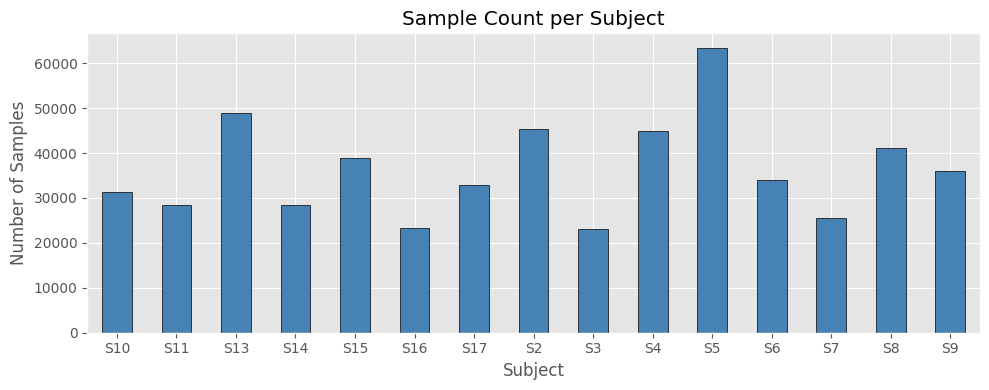

In [32]:
fig, ax = plt.subplots(figsize=(10, 4))
subject_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Sample Count per Subject')
ax.set_xlabel('Subject')
ax.set_ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Univariate Distributions

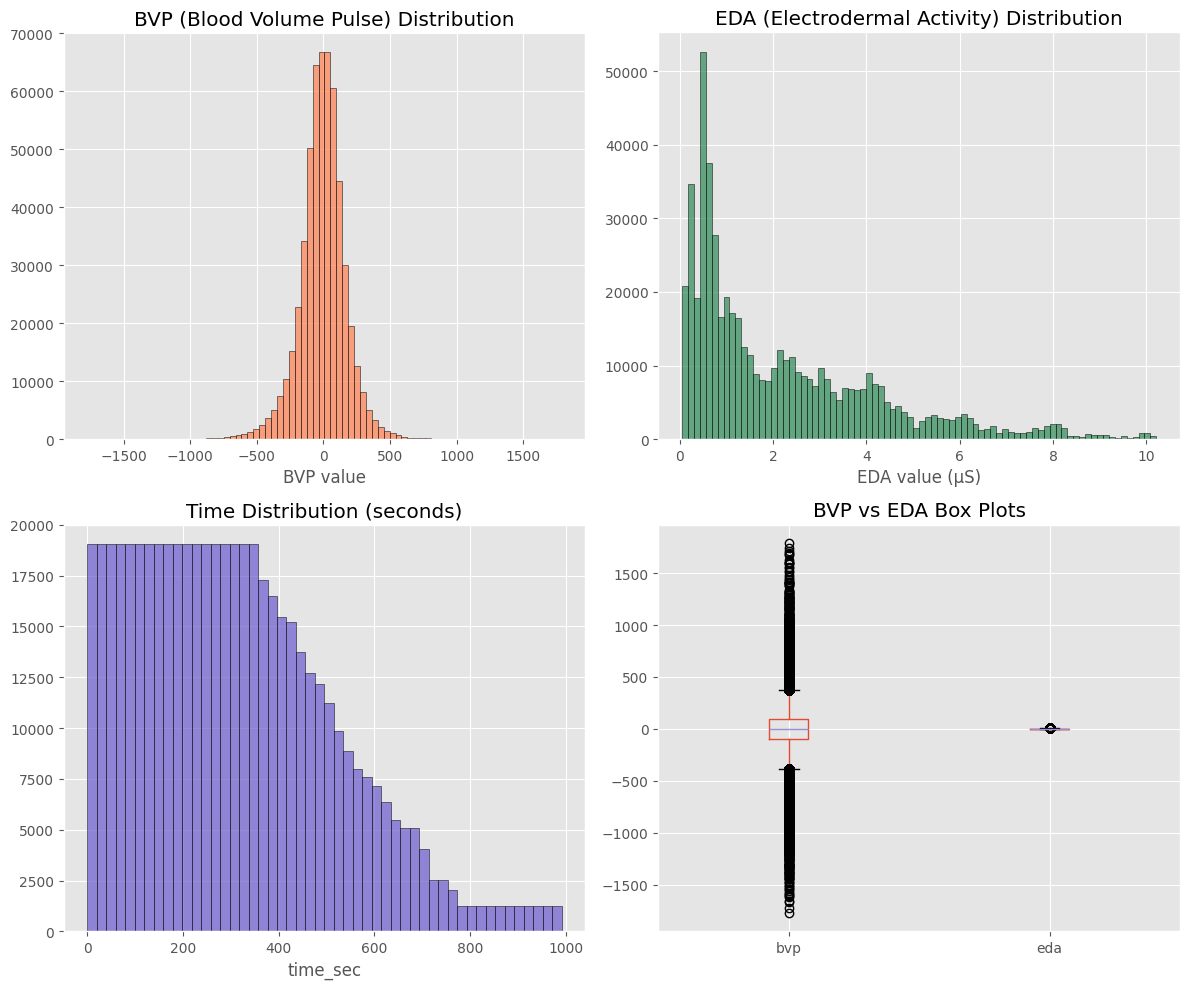

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# BVP histogram
axes[0, 0].hist(df['bvp'].dropna(), bins=80, color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('BVP (Blood Volume Pulse) Distribution')
axes[0, 0].set_xlabel('BVP value')

# EDA histogram
axes[0, 1].hist(df['eda'].dropna(), bins=80, color='seagreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('EDA (Electrodermal Activity) Distribution')
axes[0, 1].set_xlabel('EDA value (µS)')

# Time distribution
axes[1, 0].hist(df['time_sec'], bins=50, color='slateblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Time Distribution (seconds)')
axes[1, 0].set_xlabel('time_sec')

# Box plots for BVP and EDA
df[['bvp', 'eda']].boxplot(ax=axes[1, 1])
axes[1, 1].set_title('BVP vs EDA Box Plots')

plt.tight_layout()
plt.show()

## 6. Time Series Overview

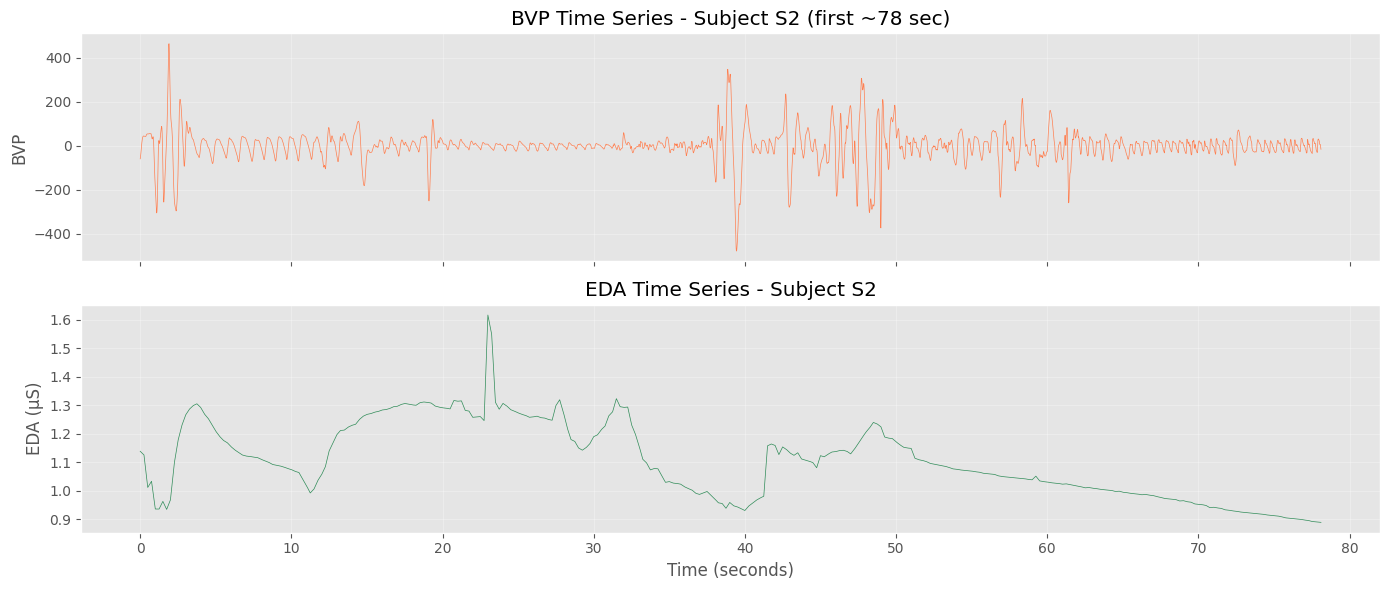

In [34]:
# Sample one subject for visualization (first 5000 points ~78 sec)
sample_subj = df['subject'].iloc[0]
sample = df[df['subject'] == sample_subj].head(5000)

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
axes[0].plot(sample['time_sec'], sample['bvp'], color='coral', linewidth=0.5)
axes[0].set_ylabel('BVP')
axes[0].set_title(f'BVP Time Series - Subject {sample_subj} (first ~78 sec)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(sample['time_sec'], sample['eda'], color='seagreen', linewidth=0.5)
axes[1].set_ylabel('EDA (µS)')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_title(f'EDA Time Series - Subject {sample_subj}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Time Series Colored by Label

BVP and EDA for one subject with segments colored by condition.

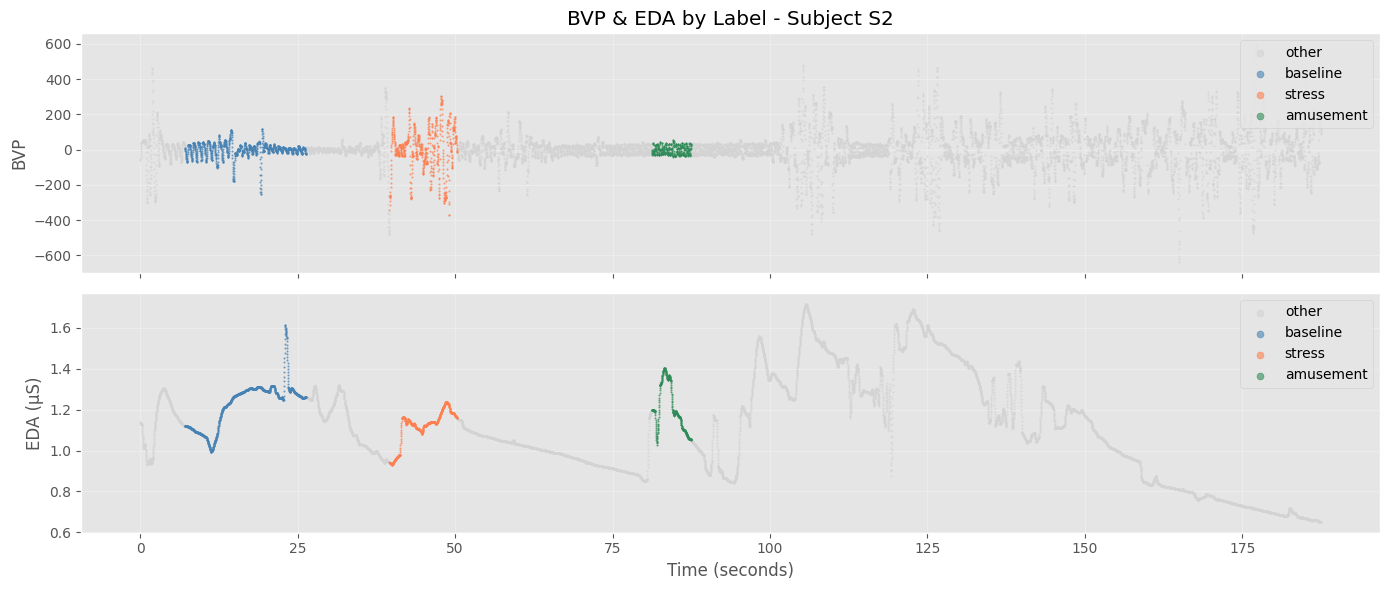

In [35]:
# Time series with label-colored segments (sample ~3 min of one subject)
sample_subj = df['subject'].iloc[0]
sample = df[df['subject'] == sample_subj].head(12000)  # ~3 min at 64 Hz

label_colors = {-1: 'lightgray', 0: 'steelblue', 1: 'coral', 2: 'seagreen'}
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

for ax, col, ylab in zip(axes, ['bvp', 'eda'], ['BVP', 'EDA (µS)']):
    for lbl in [-1, 0, 1, 2]:
        mask = sample['label'] == lbl
        if mask.any():
            ax.scatter(sample.loc[mask, 'time_sec'], sample.loc[mask, col], 
                      c=label_colors[lbl], s=1, alpha=0.6, label=label_names.get(lbl, lbl))
    ax.set_ylabel(ylab)
    ax.legend(loc='upper right', markerscale=5)
    ax.grid(True, alpha=0.3)
axes[1].set_xlabel('Time (seconds)')
axes[0].set_title(f'BVP & EDA by Label - Subject {sample_subj}')
plt.tight_layout()
plt.show()

## 7. Correlation Analysis

Correlation matrix:
          bvp       eda
bvp  1.000000  0.000308
eda  0.000308  1.000000


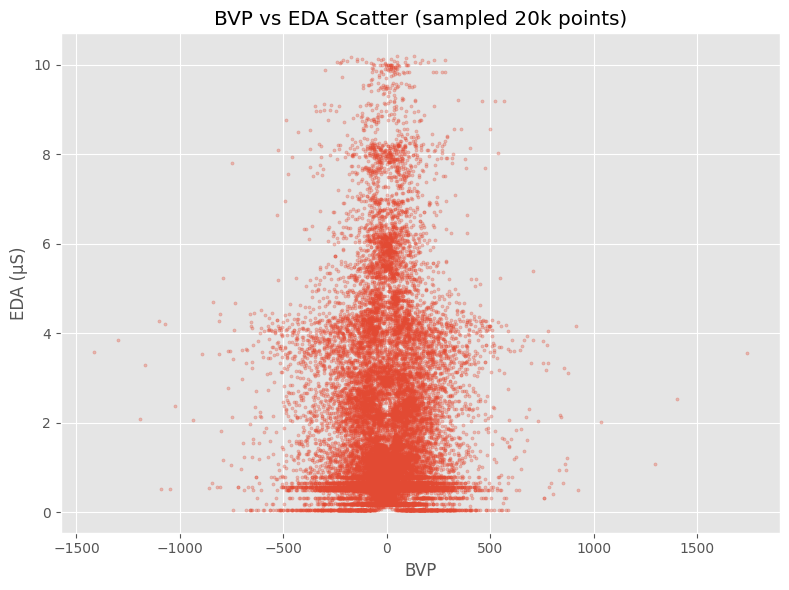

In [36]:
corr = df[['bvp', 'eda']].corr()
print('Correlation matrix:')
print(corr)

# Scatter plot (sample for readability)
sample_size = min(20000, len(df))
sample_df = df.sample(n=sample_size, random_state=42)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(sample_df['bvp'], sample_df['eda'], alpha=0.3, s=5)
ax.set_xlabel('BVP')
ax.set_ylabel('EDA (µS)')
ax.set_title('BVP vs EDA Scatter (sampled 20k points)')
plt.tight_layout()
plt.show()

## 8. Per-Subject Statistics

In [37]:
agg = df.groupby('subject').agg({
    'bvp': ['mean', 'std', 'min', 'max', 'median'],
    'eda': ['mean', 'std', 'min', 'max', 'median']
}).round(4)
agg

bvp                                        eda                  \
            mean       std      min      max median    mean     std     min   
subject                                                                       
S10      -2.9014  129.7124  -609.23   779.69 -2.090  1.9072  0.9153  0.2663   
S11      -8.4694  116.2208  -561.91   630.13 -6.295  3.7415  1.0625  1.9791   
S13     -12.0840  201.7630 -1331.36  1044.18 -4.925  5.6680  2.0761  2.8413   
S14      -7.8357  111.9729  -719.36   383.93 -4.770  0.1913  0.0618  0.0604   
S15     -10.2817  175.3978 -1056.42  1064.00 -4.810  0.7667  0.3615  0.1512   
S16      -1.6726   89.3676  -471.51   519.63 -1.040  1.3533  0.7069  0.2431   
S17       0.7426  132.3542  -793.24   833.93  0.490  1.2543  0.4710  0.6426   
S2       -6.8893  187.2002  -873.67   988.08 -1.805  0.5031  0.4765  0.0451   
S3       -0.3600  103.4705  -815.51   931.96  0.370  5.9249  1.7635  2.2487   
S4       -5.3658  174.0029 -1500.29  1245.13 -3.905  1.4429  0.8986  0.0988   
S5      -14.4428  274.3367 -1773.76  1789.00 -4.370  2.2215  1.1187  0.3520   
S6       -8.7776  145.0815  -962.66   989.96 -3.770  3.1516  0.9541  1.1285   
S7       -2.3337  109.5903  -650.81   716.57 -0.830  4.8873  0.7803  3.6870   
S8       -6.3359  185.9461 -1385.41  1330.79 -2.745  0.6229  0.1886  0.2049   
S9       -7.4417  152.7164 -1611.32   970.80 -4.215  0.6941  0.2160  0.0553   

                          
             max  median  
subject                   
S10       3.5075  2.1173  
S11       6.0955  3.3385  
S13      10.2154  5.1689  
S14       1.0339  0.1753  
S15       1.6430  0.5798  
S16       2.6063  1.2906  
S17       2.5858  1.1316  
S2        1.7174  0.4099  
S3        8.7923  6.2443  
S4        3.1190  1.4228  
S5        4.7386  2.0464  
S6        5.6365  3.2316  
S7        6.3949  4.7070  
S8        1.2821  0.5503  
S9        1.7439  0.6514

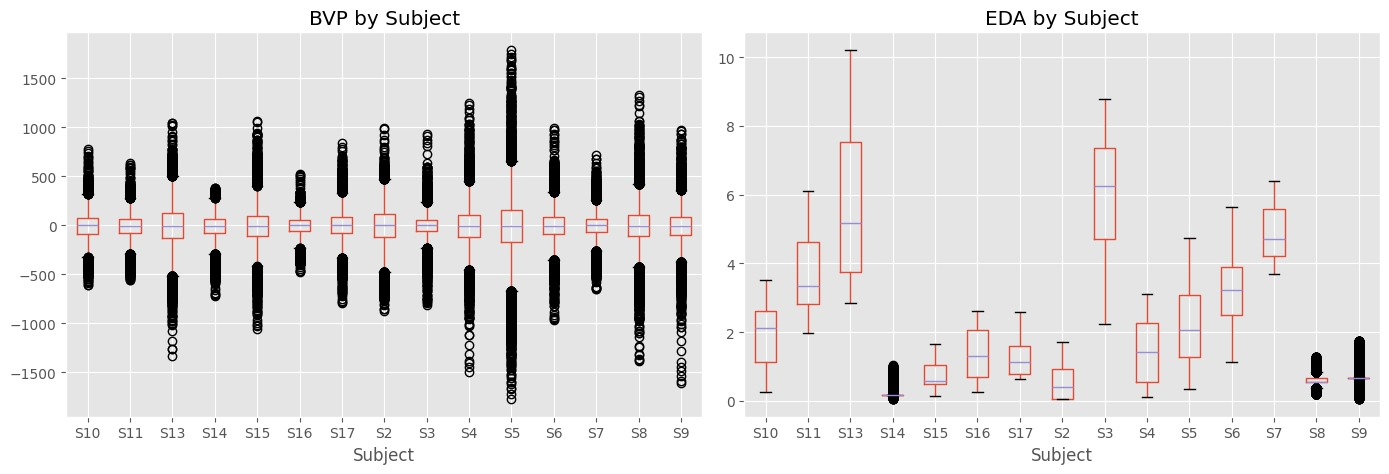

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df.boxplot(column='bvp', by='subject', ax=axes[0])
axes[0].set_title('BVP by Subject')
axes[0].set_xlabel('Subject')

df.boxplot(column='eda', by='subject', ax=axes[1])
axes[1].set_title('EDA by Subject')
axes[1].set_xlabel('Subject')

plt.suptitle('')
plt.tight_layout()
plt.show()

## 9. Outlier Detection

In [39]:
def iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)

bvp_out = iqr_outliers(df['bvp'])
eda_out = iqr_outliers(df['eda'])

print('BVP outliers (IQR method):', bvp_out.sum(), f'({bvp_out.sum()/len(df)*100:.2f}%)')
print('EDA outliers (IQR method):', eda_out.sum(), f'({eda_out.sum()/len(df)*100:.2f}%)')
print('\nBVP outlier bounds:', df['bvp'].quantile(0.25) - 1.5*(df['bvp'].quantile(0.75)-df['bvp'].quantile(0.25)), 'to',
      df['bvp'].quantile(0.75) + 1.5*(df['bvp'].quantile(0.75)-df['bvp'].quantile(0.25)))
print('EDA outlier bounds:', df['eda'].quantile(0.25) - 1.5*(df['eda'].quantile(0.75)-df['eda'].quantile(0.25)), 'to',
      df['eda'].quantile(0.75) + 1.5*(df['eda'].quantile(0.75)-df['eda'].quantile(0.25)))

BVP outliers (IQR method): 22322 (4.09%)
EDA outliers (IQR method): 18731 (3.43%)

BVP outlier bounds: -382.04 to 375.08000000000004
EDA outlier bounds: -3.4177592812500004 to 7.32074296875


## 10. Sampling Rate Verification

In [40]:
# Verify 64 Hz: delta should be ~1/64 sec
sample = df[df['subject'] == df['subject'].iloc[0]].head(100)
deltas = sample['time_sec'].diff().dropna()
print('Expected sampling interval: 1/64 =', 1/64, 'sec')
print('Observed mean interval:', deltas.mean(), 'sec')
print('Observed std of intervals:', deltas.std(), 'sec')
print('Implied sampling rate:', 1/deltas.mean(), 'Hz')

Expected sampling interval: 1/64 = 0.015625 sec
Observed mean interval: 0.015625 sec
Observed std of intervals: 0.0 sec
Implied sampling rate: 64.0 Hz
